<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Modelos polarimetría Mueller </font>
</div>

- **Para**: Paper calibración SLM Mueller

- **Fecha**: 2023/01/26
        
- **Autores**: Jesús del Hoyo

- **Objetivos**: Tener un resumen claro de los modelos de polarimetría Mueller de la literatura y nuestro.

- **Descripción** 

- **Referencias**: Al final del todo.


# Extension métodos Stokes-Mueller

Siguiendo en la línea de los métodos de Stokes-Mueller, voy a comprobar qué ocurre si uso otras figuras geométricas en diferentes combinaciones.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import optimize
import sympy as sy
from copy import deepcopy
from pyswarms.single.global_best import GlobalBestPSO
from itertools import combinations

from py_pol.mueller import Mueller, Stokes, degrees
from py_lab.config import angle_P1, angle_Q1, angle_Q2, angle_P2
from py_lab.utils import PSA_states_2_angles, PSG_states_2_angles, PSA_angles_2_states, PSG_angles_2_states
import matplotlib.pyplot as plt

In [3]:
def W_from_S(S_PSG, S_PSA):
    """Funcion para calcular la matriz W a partir de los estados del PSG y del PSA.

    Args:
        S_PSG (Stokes): States of the PSG.
        S_PSA (Stokes): States of the PSA.

    Returns:
        W (np.ndarray): W matrix.
    """
    # Prealocate matrix
    N = S_PSA.size * S_PSG.size
    W = np.zeros((N,16))

    # Calculate matrix
    ind = 0
    for ind_G in range(S_PSG.size):
        for ind_A in range(S_PSA.size):
            # Calculate row
            MA = S_PSA.M[:,ind_A, np.newaxis]
            MG = S_PSG.M[np.newaxis,:,ind_G]
            M = MA @ MG

            # Assign row
            W[ind,:] = 0.5 * M.flatten()
            ind += 1

    return W

In [4]:
def W_inv(W):
    """Calculate the inverse or pseudoinverse matrix of W.

    Args:
        W (np.ndarray): W matrix to invert.

    Returns:
        Wi (np.ndarray): Inverse matrix.
    """
    # Caso N = 16
    if W.shape[0] == W.shape[1]:
        if np.linalg.matrix_rank(W) == W.shape[0]:
            Wi = np.linalg.inv(W)
        else:
            print("WARNING: Non-invertible matrix")
            return W
    # Casos N > 16
    else:
        Wi = np.linalg.inv(W.T @ W) @ W.T

    return Wi

In [5]:
def norma_Frobenius(W):
    """Norma de Frobenius.

    Args:
        W (np.ndarray): Matriz W

    Returns:
        n (float): Norma de la matriz.
    """
    return np.linalg.norm(W)

def norma_Vect2(W):
    """Norma vectorial de orden dos.

    Args:
        W (np.ndarray): Matriz W

    Returns:
        n (float): Norma de la matriz.
    """
    _, singular, _ = np.linalg.svd(W)
    return singular.max()/singular.min()

def condition_number(W, f_norma):
    """Calcula el condition number de una matriz NxM.

    Args:
        W (np.ndarray): Matriz W

    Returns:
        kappa (float): Condition number
    """
    Wi = W_inv(W)
    return f_norma(W) * f_norma(Wi) # / (W.shape[0]/16)**(1)

## Poliedros regulares

Vamos a usar estados colocados en los vértices de los poliedros regulares que son los únicos en los que se asegura que la distancia entre ellos es máxima.

In [12]:
# Estados
phi = (1+np.sqrt(5))/2
r3 = np.sqrt(3)
raiz = np.sqrt(1 + phi**2)

Tetraedro = np.array([[1, 1, 0, 0], [1, -1/3, np.sqrt(8)/3, 0], [1, -1/3, -np.sqrt(2)/3, np.sqrt(6)/3], [1, -1/3, -np.sqrt(2)/3, -np.sqrt(6)/3]]).T
Octaedro = np.array([[1, 1, 0, 0], [1, -1, 0, 0], [1, 0, 1, 0], [1, 0, -1, 0], [1, 0, 0, 1], [1, 0, 0, -1] ]).T
Cubo = np.array([[r3, 1, 1, 1], [r3, 1, 1, -1], [r3, 1, -1, 1], [r3, -1, 1, 1], [r3, -1, -1, 1], [r3, -1, 1, -1], [r3, 1, -1, -1], [r3, -1, -1, -1]]) / r3
Icosaedro = np.array([[raiz, 0, 1, phi], [raiz, 0, -1, phi], [raiz, 0, 1, -phi], [raiz, 0, -1, -phi], 
    [raiz, 1, phi, 0], [raiz, -1, phi, 0], [raiz, 1, -phi, 0], [raiz, -1, -phi, 0],
    [raiz, phi, 0, 1], [raiz, -phi, 0, 1], [raiz, phi, 0, -1], [raiz, -phi, 0, -1],
]) / raiz
Dodecaedro = np.array([[r3, 1, 1, 1], [r3, 1, 1, -1], [r3, 1, -1, 1], [r3, -1, 1, 1], [r3, -1, -1, 1], [r3, -1, 1, -1], [r3, 1, -1, -1], [r3, -1, -1, -1], 
    [r3, 0, phi, 1/phi], [r3, 0, -phi, 1/phi], [r3, 0, phi, -1/phi], [r3, 0, -phi, -1/phi], 
    [r3, 1/phi, 0, phi], [r3, -1/phi, 0, phi], [r3, 1/phi, 0, -phi], [r3, -1/phi, 0, -phi], 
    [r3, phi, 1/phi, 0], [r3, -phi, 1/phi, 0], [r3, phi, -1/phi, 0], [r3, -phi, -1/phi, 0], ]) / r3

S_4 = Stokes().from_matrix(Tetraedro)
S_6 = Stokes().from_matrix(Octaedro)
S_8 = Stokes().from_matrix(Cubo)
S_12 = Stokes().from_matrix(Icosaedro)
S_20 = Stokes().from_matrix(Dodecaedro)
lista = [S_4, S_6, S_8, S_12, S_20]

In [19]:
# Combinaciones
N = len(lista)
error = np.zeros((N,N))
kappa_perfect = np.zeros((N,N))
Nmeasures_perfect = np.zeros((N,N))
for ind_PSG, S_PSG in enumerate(lista):
    for ind_PSA, S_PSA in enumerate(lista):
        W = W_from_S(S_PSG, S_PSA)
        Wi = W_inv(W)
        Id = Wi @ W
        error[ind_PSG, ind_PSA] = np.sum((Id - np.eye(Id.shape[0]))**2)
        kappa_perfect[ind_PSG, ind_PSA] = condition_number(W, norma_Vect2)
        Nmeasures_perfect[ind_PSG, ind_PSA] = S_PSG.size * S_PSA.size

In [20]:
print("error:", error, sep="\n")
print("kappa:", kappa_perfect, sep="\n")
print("Nmeasures:", Nmeasures_perfect, sep="\n")
print(np.sort(Nmeasures_perfect.flatten()))

error:
[[9.25843989e-31 4.00608409e-30 1.49057794e-29 1.11628157e-29
  8.14636151e-30]
 [9.02547372e-31 5.21927015e-32 1.65645739e-30 4.04407111e-30
  3.94648806e-30]
 [3.98094533e-30 1.73454489e-30 1.62874730e-29 6.15401310e-29
  4.76402178e-29]
 [4.93797037e-30 9.50270238e-30 9.43209314e-29 6.33440940e-30
  6.01189794e-30]
 [6.98029668e-30 1.14074901e-29 4.53659391e-29 8.72745159e-30
  4.36600093e-30]]
kappa:
[[9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9.]]
Nmeasures:
[[ 16.  24.  32.  48.  80.]
 [ 24.  36.  48.  72. 120.]
 [ 32.  48.  64.  96. 160.]
 [ 48.  72.  96. 144. 240.]
 [ 80. 120. 160. 240. 400.]]
[ 16.  24.  24.  32.  32.  36.  48.  48.  48.  48.  64.  72.  72.  80.
  80.  96.  96. 120. 120. 144. 160. 160. 240. 240. 400.]


Demostración de que los poliedros regulares ofrecen el mejor resultado posible.

### Despolarizacion

Si meto despolarizacion en estos estados, ¿mejora la cosa?

In [18]:
S_4_desp = S_4.set_depolarization(degree_pol=0.9, keep=False)
print(S_4_desp)

W = W_from_S(S_4_desp, S_4_desp)
Wi = W_inv(W)
Id = Wi @ W
error = np.sum((Id - np.eye(Id.shape[0]))**2)
kappa = condition_number(W, norma_Vect2)

print("error:", error, sep="\n")
print("kappa Tetraedro despolarizado:", kappa, sep="\n")

S depolarized depolarized depolarized depolarized depolarized depolarized = 
[+1.000]   [+1.000]   [+1.000]   [+1.000]   
[+0.900]   [-0.300]   [-0.300]   [-0.300]   
[+0.000]   [+0.849]   [-0.424]   [-0.424]   
[+0.000]   [+0.000]   [+0.735]   [-0.735]   

error:
1.6639611609622016e-30
kappa Tetraedro despolarizado:
13.717421124828538


Como era de esperar, el condition number aumenta.

## Otras maneras de distribuir los puntos

Existen maneras de distribuir los puntos en una esfera más o menos equiespaciadas. Vamos a ver qué se obtiene.

### Espiral

Vamos a distribuir los puntos en la esfera de Poincare con una erspiral. Es esperable que funcione mejor cuantos más puntos se usen.

In [12]:
def fill_sphere_fibonacci(num_samples=100, kind_exit='list', has_draw=False):
    """Generate a quasi - uniform distribution around the poincare sphere.

    Arguments:
        num_samples(int): number of samples.
        kind_exit(str): ('list', 'numpy_array', 'Stokes', 'Jones')

    Reference:
         https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    """
    golden_angle = np.pi * (3. - np.sqrt(5.))  # golden angle in radians

    i = np.linspace(0, num_samples, num_samples)
    y = 1 - (i / (num_samples - 1)) * 2
    y[y > 1] = 1
    y[y < -1] = -1
    radius = np.sqrt(1 - y**2)  # radius at y
    theta = golden_angle * i  # golden angle increment
    x = np.cos(theta) * radius
    z = np.sin(theta) * radius

    if kind_exit == 'list':
        return (x, y, z)
    elif kind_exit == 'numpy_array':
        return np.vstack((x, y, z)).transpose()
    elif kind_exit == 'Stokes':
        S = Stokes("S1").from_components([np.ones_like(x), x, y, z])
        return x, y, z, S
    elif kind_exit == 'Jones':
        S = Stokes("S1").from_components([np.ones_like(x), x, y, z])
        J = Jones_vector().from_Stokes(S)
        return x, y, z, J
    else:
        print("No kind_exit parameter")
        return None

In [17]:
States = np.repeat(np.arange(4, 21), 2)
kappa_spiral = np.zeros(States.size - 1)
error = np.zeros(States.size - 1)
Nmeasures_spiral = np.zeros(States.size - 1)

for ind, N1 in enumerate(States[:-1]):
    N2 = States[ind+1]
    _,_,_,S1 = fill_sphere_fibonacci(num_samples=N1, kind_exit='Stokes', has_draw=False)
    _,_,_,S2 = fill_sphere_fibonacci(num_samples=N2, kind_exit='Stokes', has_draw=False)
    W = W_from_S(S1, S2)
    Wi = W_inv(W)
    Id = Wi @ W
    error[ind] = np.sum((Id - np.eye(Id.shape[0]))**2)
    kappa_spiral[ind] = condition_number(W, norma_Vect2)
    Nmeasures_spiral[ind] = N1 * N2

print("error:", error, sep="\n")
print("kappa:", kappa_spiral, sep="\n")
print("Nmeasures:", Nmeasures_spiral, sep="\n")

error:
[7.02847629e-25 8.81457772e-24 5.66023161e-26 6.52225490e-27
 1.37955905e-27 4.23513425e-28 7.21061619e-29 2.73192308e-29
 5.17046230e-30 5.97749862e-30 3.82510401e-30 5.92019345e-30
 2.87405252e-30 4.40954682e-30 4.79953786e-30 3.84398094e-30
 5.16647260e-30 2.84329239e-30 3.86398907e-30 5.28972668e-30
 2.08972078e-30 2.86356937e-30 4.78832116e-30 2.91032394e-30
 5.17864746e-30 3.24747810e-30 2.32196568e-30 4.13897306e-30
 7.40503696e-30 5.61165069e-30 7.59901155e-30 3.75581463e-30
 2.79568888e-30]
kappa:
[8.98969994e+07 3.74206195e+06 1.55767464e+05 1.90317849e+04
 2.32531767e+03 8.69108322e+02 3.24837026e+02 1.65010457e+02
 8.38218818e+01 5.45627898e+01 3.55169554e+01 2.66421039e+01
 1.99848690e+01 1.68487697e+01 1.42047987e+01 1.49862488e+01
 1.58106889e+01 1.58051774e+01 1.57996678e+01 1.50323423e+01
 1.43022828e+01 1.35403351e+01 1.28189798e+01 1.26534607e+01
 1.24900788e+01 1.25984145e+01 1.27076899e+01 1.26054190e+01
 1.25039711e+01 1.21289801e+01 1.17652349e+01 1.155269

Efectivamente, para N bajo funciona muy mal mientras que para N altos se acerca mucho al óptimo de 9.

### Aleatorios

Por último, voy a calcular el resultado de usar ángulos aleatorios. Como son aleatorios, repetiré cada caso muchas veces para poder hacer un promedio.

In [48]:
Nmeasures = np.linspace(16, 400, 35, dtype=int)
kappa_random = np.zeros_like(Nmeasures, dtype=float)
error_random = np.zeros_like(Nmeasures, dtype=float)
Naverage = 50

for ind, N in enumerate(Nmeasures):
    # Promediar para calcular desviacion tipica
    kappa = []
    for indM in range(Naverage):
        angles = np.random.rand(4, N) * 180*degrees
        W = angles_to_W(angles)
        Wi = W_inv(W)
        Id = Wi @ W
        error = np.sum((Id - np.eye(Id.shape[0]))**2)
        if error < 1e-10:
            kappa.append(condition_number(W, norma_Vect2))

    # Resultado
    kappa_random[ind] = np.average(kappa)
    error_random[ind] = np.std(kappa)
            

print("error:", error_random, sep="\n")
print("kappa:", kappa_random, sep="\n")
print("Nmeasures:", Nmeasures, sep="\n")

error:
[3.47793689e+05 2.43077036e+02 3.12301570e+01 1.77624964e+01
 1.26439247e+01 7.42303459e+00 8.16130242e+00 6.64644719e+00
 6.61196973e+00 4.58381942e+00 4.35044243e+00 3.80127757e+00
 3.59082887e+00 3.50317997e+00 3.72695077e+00 3.14679229e+00
 3.28228179e+00 2.73319811e+00 2.52436046e+00 2.92849664e+00
 2.26586592e+00 2.45125384e+00 2.00417067e+00 2.01576848e+00
 1.97358787e+00 2.25147027e+00 1.71282393e+00 1.93683900e+00
 1.92066068e+00 1.64715773e+00 1.88882944e+00 2.00179953e+00
 1.74943421e+00 1.73387663e+00 1.95661533e+00]
kappa:
[1.19400004e+05 2.52617316e+02 8.45858172e+01 5.33876713e+01
 4.41815449e+01 3.84744045e+01 3.62868027e+01 3.19505726e+01
 3.02718208e+01 2.90173652e+01 2.74592917e+01 2.67117129e+01
 2.56980092e+01 2.51655407e+01 2.51443365e+01 2.47463975e+01
 2.45566369e+01 2.34744733e+01 2.30218212e+01 2.32840952e+01
 2.24283390e+01 2.21456646e+01 2.20927002e+01 2.22049864e+01
 2.17164508e+01 2.18981379e+01 2.13597753e+01 2.08264898e+01
 2.08897754e+01 2.095032

## Comparación de métodos

Voy a comparar el resultado de los diferentes métodos visualmente con figuras.

In [36]:
Nmeasures_perfect = Nmeasures_perfect.flatten()
kappa_perfect = kappa_perfect.flatten()
args = np.argsort(Nmeasures_perfect)
Nmeasures_perfect = Nmeasures_perfect[args]
kappa_perfect = kappa_perfect[args]

(15.0, 30.0)

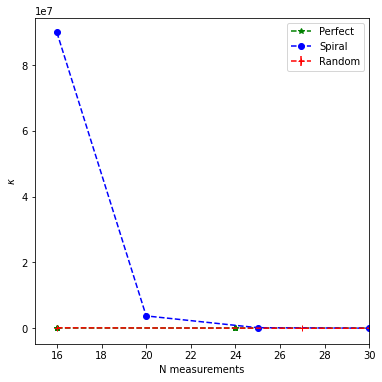

In [49]:
plt.figure(figsize=(6,6))
plt.plot(Nmeasures_perfect, kappa_perfect, "g*--", label="Perfect")
plt.plot(Nmeasures_spiral, kappa_spiral, "bo--", label="Spiral")
plt.errorbar(Nmeasures, kappa_random, yerr=error_random, fmt="r+--", label="Random")
plt.legend()
plt.xlabel("N measurements")
plt.ylabel("$\kappa$")
plt.xlim([15,30])

(0.0, 200.0)

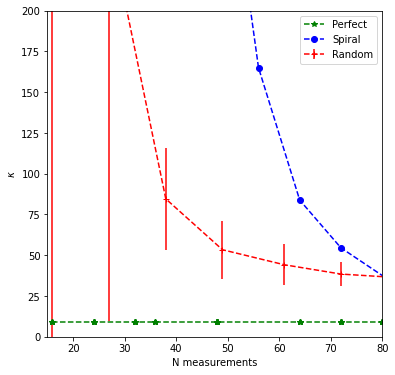

In [50]:
plt.figure(figsize=(6,6))
plt.plot(Nmeasures_perfect, kappa_perfect, "g*--", label="Perfect")
plt.plot(Nmeasures_spiral, kappa_spiral, "bo--", label="Spiral")
plt.errorbar(Nmeasures, kappa_random, yerr=error_random, fmt="r+--", label="Random")
plt.legend()
plt.xlabel("N measurements")
plt.ylabel("$\kappa$")
plt.xlim([15,80])
plt.ylim([0,200])

(0.0, 50.0)

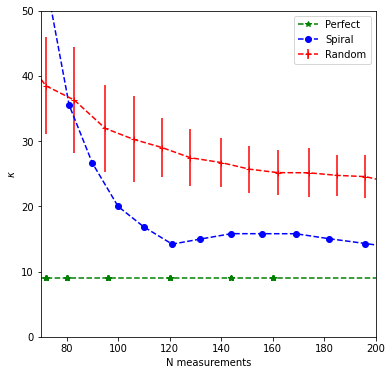

In [51]:
plt.figure(figsize=(6,6))
plt.plot(Nmeasures_perfect, kappa_perfect, "g*--", label="Perfect")
plt.plot(Nmeasures_spiral, kappa_spiral, "bo--", label="Spiral")
plt.errorbar(Nmeasures, kappa_random, yerr=error_random, fmt="r+--", label="Random")
plt.legend()
plt.xlabel("N measurements")
plt.ylabel("$\kappa$")
plt.xlim([70,200])
plt.ylim([0,50])

In [52]:
plt.figure(figsize=(6,6))
plt.plot(Nmeasures_perfect, kappa_perfect, "g*--", label="Perfect")
plt.plot(Nmeasures_spiral, kappa_spiral, "bo--", label="Spiral")
plt.errorbar(Nmeasures, kappa_random, yerr=error_random, fmt="r+--", label="Random")
plt.legend()
plt.xlabel("N measurements")
plt.ylabel("$\kappa$")
plt.xlim([200,410])
plt.ylim([0,30])

(0.0, 30.0)

Es interesante comprobar cómo la espiral es peor que los ángulos aleatorios hasta las 75-90 medidas, a aprtir de ahí los ángulos aleatorios prácticamente no bajan mientras que con la espiral van descendiendo lentamente (con un pequeño repunte entre 121 y 140 medidas y un estancamiento entre 250 y 300 medidas). Por supuesto, usar solidos regulares siempre es óptimo.

También se pueed apreciar que el efecto de pasar de 200 a 400 medidas es prácticamente nulo, por lo que no merece la pena el esfuerzo de realizar tantas (al menos desde el punto de vista del condition number $\kappa$).